In [1]:
from random import randint
def randhex():
    r = lambda: randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))
import warnings
warnings.filterwarnings('ignore')

# cartopy  <small> Cartographic accuracy in Python </small>

`cartopy` is a Python package for the purpose of making accurate cartographic projections fun and easy. It is the successor to `basemap`, which is included in the `matplotlib` plotting package. `cartopy` is a more flexible and and easier-to-use package which integrates nicely into matplotlib visualizations. 

## Table of Contents

0. [First, A Primer](#First,-A-Primer)
1. [Map Features + Shapes](#Map-Features-+-Shapes)
2. [Pre-Defined Projections](#Pre-Defined-Projections)


## First, A Primer

The Earth is round (ok, ellipsoidal), paper and computer screens are flat. This means that when we attempt to flatten our round planet to the two-dimensional plane of websites and journal articles, we make certain assumptions based on the intent we've set for our map. 

For example, perhaps a low areal distortion is critical (i.e. a two-cm square anywhere on our paper map has the same surface area on the globe), or perhaps preserving the 'real' shapes of landmasses is important. Each set of assumptions and tradeoffs we create is referred to as a "projection," and consists of a set of equations which convert spherical (or, in the case of Earth, ellipsoidal) coordinates into planar coordinates. 

Those "spherical coordinates" I mention above are referencing a location on a sphere (or, in the case of Earth, an elipse), and as such they have to be *in reference to some definition of that sphere*. We call that reference point a **datum**, which defines the surface upon which the unprojected spherical coordinates lie. There are several important datums, like WGS84 (used by GPS systems) and NAD83, which you'll see often. They each define a different version of the Earth's geometry, and that's all we'll say about that here (it's easy to get into a rabbit hole with datums/geographic reference systems, so we'll avoid that). For more on this, start at [this discussion](https://gis.stackexchange.com/questions/664/whats-the-difference-between-a-projection-and-a-datum) (thanks Randy for the reference!).

There is no theoretical limit to the number of map projections. However, there is a (growing) set of standard projections which have each been accepted by the cartographic community as being well-suited for a large class of geospatial applications. The list of the available projections which have their own named function in cartopy can be found [here](http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html). 

Each of these projections has been assigned a code by the European Petroleum Survey Group (EPSG), which has established itself as a projection authority. This has made using specific projections quite simple, as one can refer to them by their EPSG code. The EPSG code for the Web Mercator projection (used by Google Maps and Bing Maps), for example, is EPSG:3857. You can explore projections and find your neighborhood's favorite at http://epsg.io, which is also the database cartopy uses to lookup projections by their EPSG codes. 

Cartopy is capable of projecting into arbitrary planar space using the `proj.4` projection specification system in Python, and can access any projection with an EPSG code. We'll practice this later. 

See [here](https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e) for a nice visualization of different projections by github user [`syntagmatic`](https://github.com/syntagmatic). 

## Map Features + Shapes
Taking a cue from `matplotlib`'s `basemap`, `cartopy` includes utilities for constructing a map upon which some geospatial data can be plot, like country borders and waterways. Before diving into projections we'll start by taking a look at what's available there. 

The `shapereader` class is used for reading shapefiles, which are an ESRI-derived format (the ArcMap company). `shapereader` comes pre-packaged with a downloader/reader of the [Natural Earth](http://www.naturalearthdata.com/) dataset, an extensive set of free vector and raster map features. There are two ways to access this NaturalEarth data: as a raw shapefile, and as a `cartopy` `Feature` object. We'll start with the raw shapefile. 

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
_DEFAULT_PROJECTION = ccrs.Mercator().GOOGLE
%matplotlib inline

## uncomment the line below if you want fancy high-resolution plots
## which will take a long time to load
#%config InlineBackend.figure_format = 'retina'


Once we've loaded the `shapereader` class from the `cartopy.io` module, we can use the `natural_earth` function to access the shapefiles. 

In [3]:
shapename = 'admin_1_states_provinces_lakes_shp' # specified at http://naturalearthdata.com

# Download (or find locally) the shapefile.
states_shp = shapereader.natural_earth(resolution='50m',
                                       category='cultural',
                                       name=shapename)

states_shp

'/home/havahol/.local/share/cartopy/shapefiles/natural_earth/cultural/50m_admin_1_states_provinces_lakes_shp.shp'

To plot the polygons inside this shapefile, we

* set up a basic matplotlib figure
* define the plot's projection with the `projection=` keyword argument to `plt.axes`
* set the extent of our map with `ax.set_extent` (which requires you to specify the coordinate system in which you're describing your extent; here we're using a geodetic system of lon/lat coordinates in the format [lonmin, lonmax, latmin, latmax] which is a specific form of matplotlib's generalized [xmin, xmax, ymin, ymax] boundary specification).
* iterate through all of the geometries in the `states_shp` shapereader and plot them, each with a random color. 

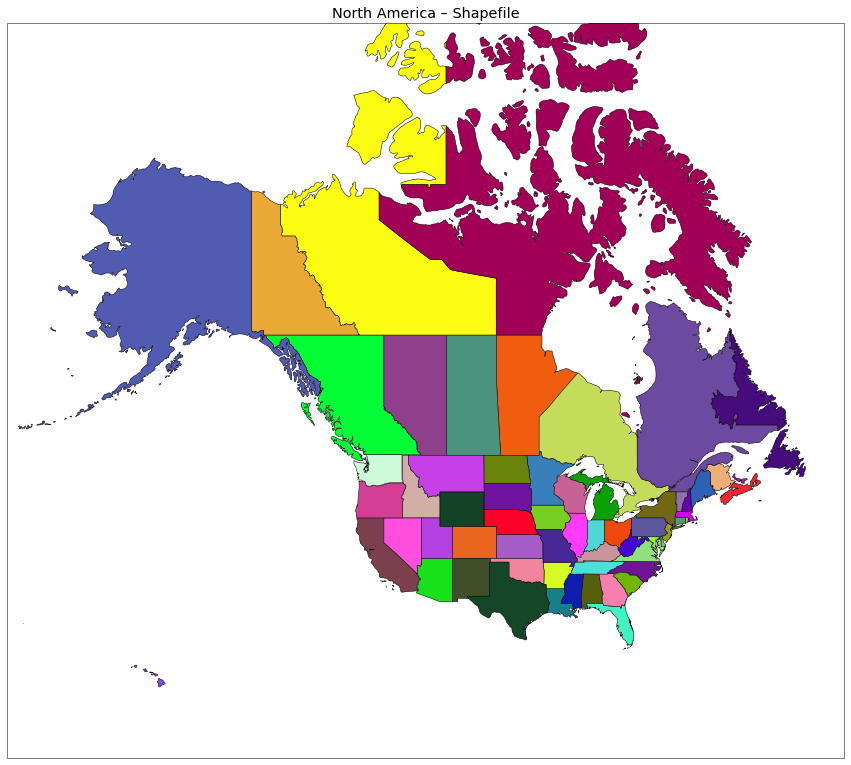

In [4]:
fig = plt.figure(figsize=(15, 15)) 
ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – Shapefile")
for state in shapereader.Reader(states_shp).geometries(): # plot each geometry with different color. 
    ax.add_geometries(state, ccrs.PlateCarree(), facecolor=randhex(), edgecolor='black')

Because we downloaded the raw `'admin_1_states_provinces_lakes_shp'` shapefile from Natural Earth, we can iterate through all of the geometries and specify visualization information for each (see the `facecolor` and `edgecolor` arguments to `add_geometries`, above). 

The `shapereader.Reader` module can read any shapefile. 

If we don't need this level of granularity in our visualization, `cartopy` has a module which does much of the heavy-lifting for us: the `feature` module. Here we'll make the same plot as above, but using a different method. 

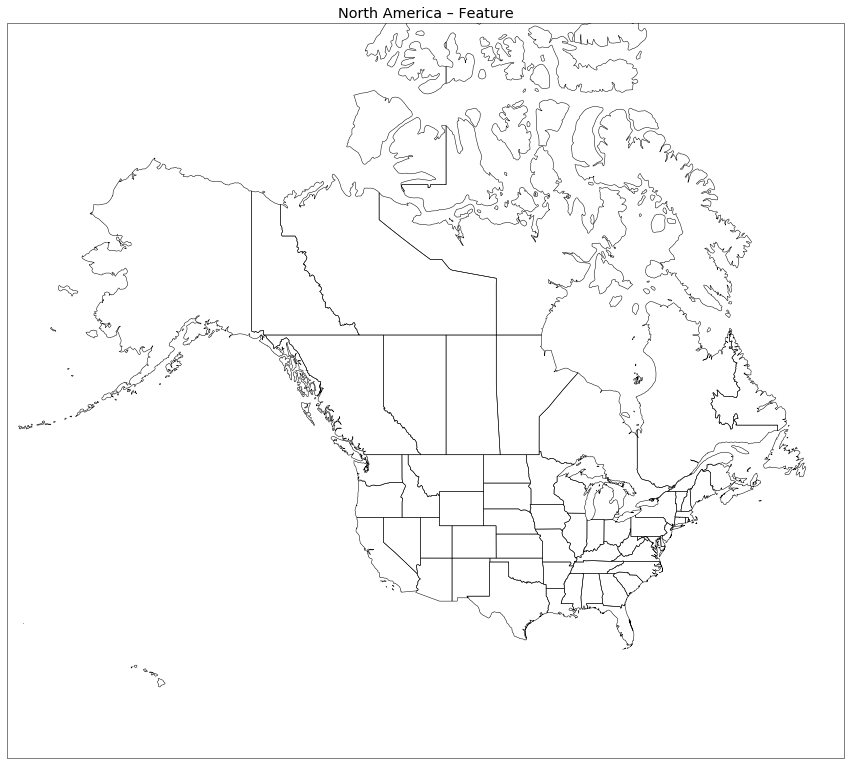

In [5]:
import cartopy.feature as feature

states_feature = feature.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes_shp', 
                                             scale='50m',
                                             facecolor='none', 
                                            edgecolor='black')

fig = plt.figure(figsize=(15, 15)) 
ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – Feature")
ax.add_feature(states_feature)

As you can see, this plot is equivalent. However, I can't add individual color to each state/province like I can with the shapefile method: it's either all one color, or all `'none`', as I've set above. 

There's also `cartopy.feature.BORDERS`, `cartopy.feature.COASTLINE`, `cartopy.feature.LAKES`, `cartopy.feature.LAND`, `cartopy.feature.OCEAN`, and `cartopy.feature.RIVERS` for even easier basemap creation (all data is from NaturalEarth). 

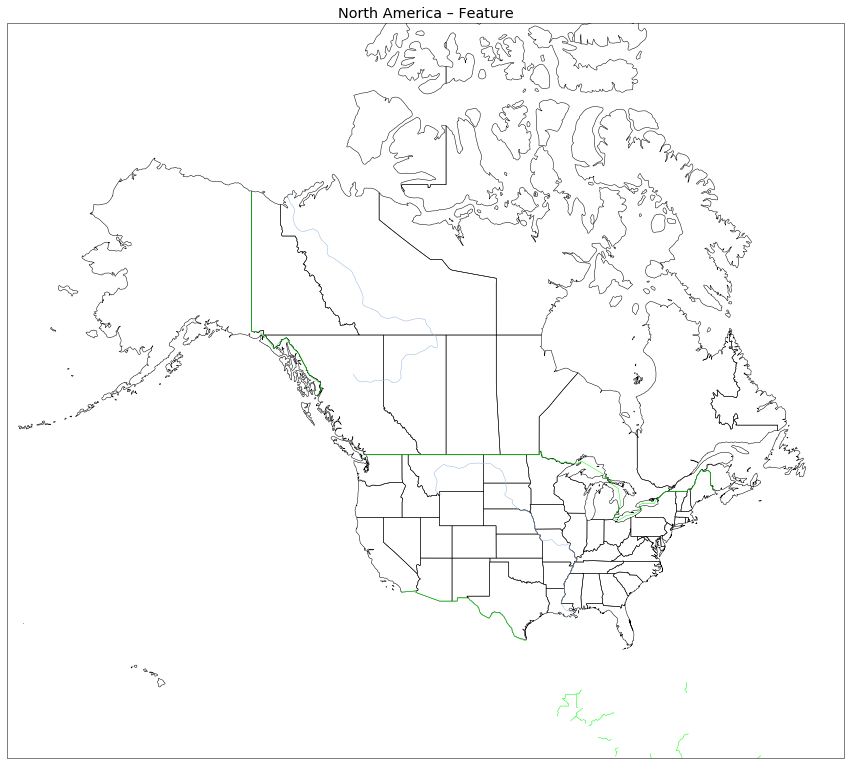

In [6]:
fig = plt.figure(figsize=(15, 15)) 
ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – Feature")
ax.add_feature(states_feature)
ax.add_feature(feature.RIVERS)
ax.add_feature(feature.BORDERS, edgecolor='lime')

## Pre-Defined Projections
Cartopy comes pre-loaded with lots of projections. You can see them all [here](http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html). We'll play around with a couple of them, just for fun. Let's remake the above plots with the new projection. To each plot I've added a series of equal-area orange dots which serve as a sort of indicator of the distortion that each map projection produces (this is known as *Tissot's indicatrix*, you can read more about it [here](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) if you want to). Think about laying identical rubber circles on the surface of the planet--the projection stretches or shrinks these circles, which is evident in the indicatrix.

We'll start by giving a name to the projection we've been using above: it's called the Mercator projection (specifically, the Web Mercator, because it's used by most popular online map websites [google, bing])

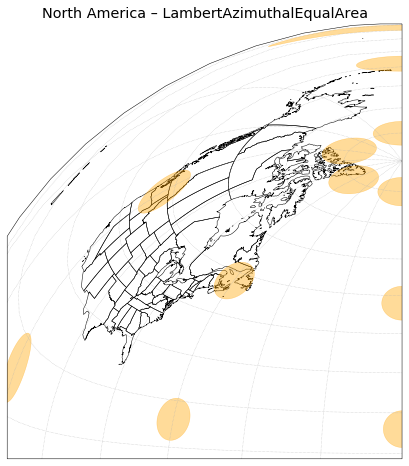

In [10]:
fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – LambertAzimuthalEqualArea")
ax.add_feature(states_feature)
ax.gridlines(linestyle=":")
ax.tissot(color='orange', alpha=0.4)

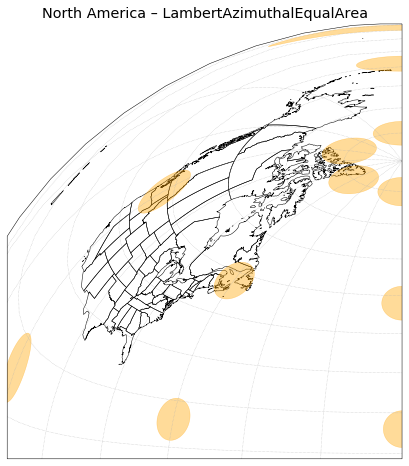

In [8]:
fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea())
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – LambertAzimuthalEqualArea")
ax.add_feature(states_feature)
ax.gridlines(linestyle=":")
ax.tissot(color='orange', alpha=0.4)

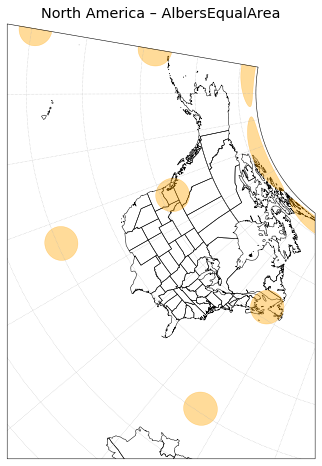

In [11]:
fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.AlbersEqualArea())
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – AlbersEqualArea")
ax.add_feature(states_feature)
ax.gridlines(linestyle=":")
ax.tissot(color='orange', alpha=0.4)

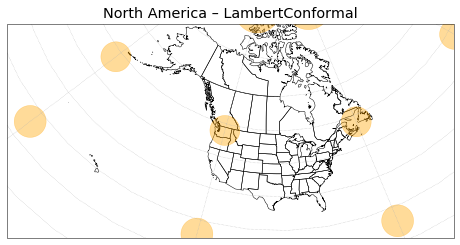

In [12]:
fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – LambertConformal")
ax.add_feature(states_feature)
ax.gridlines(linestyle=":")
ax.tissot(color='orange', alpha=0.4)

### Specific Projections
Perhaps we're working with a specific use-case for our data: let's say we need high-resolution plots of areas in Washington (perhaps, Seattle). We can use the Washington specific spatial reference systems ([EPSG 2926](http://spatialreference.org/ref/epsg/2926/) for Northern Washington and [EPSG 2927](http://spatialreference.org/ref/epsg/2927/) for Southern Washington). To tell cartopy how to project into our specific space, we can use the `crs.epsg()` function, which uses http://epsg.io to lookup the projection information for a given EPSG code. 

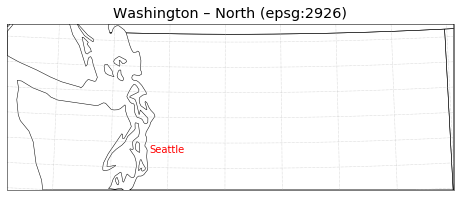

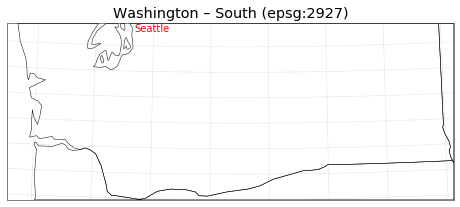

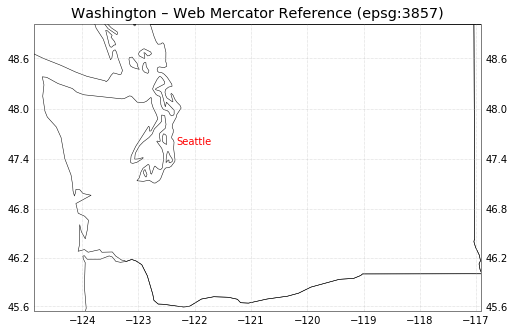

In [13]:
WASHINGTON_NORTH = 2926
WASHINGTON_SOUTH = 2927
SEATTLE_BOUNDS = [-122.4596959,-122.2244331,47.4919119,47.734145]
WASHINGTON_BOUNDS = [-124.849,-116.9156,45.5435,49.0024]
SEATTLE_CENTER = (-122.3321, 47.6062)

fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.epsg(WASHINGTON_NORTH))
#ax.set_extent(<NO EXTENT>) # not setting bounds means we can see the full extent of the projected space.
ax.set_title("Washington – North (epsg:2926)")
ax.add_feature(states_feature)
ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
            ha='left', va='center')
ax.gridlines(linestyle=":")
ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')
plt.show()

fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=ccrs.epsg(WASHINGTON_SOUTH))
#ax.set_extent(<NO EXTENT>) # not setting bounds means we can see the full extent of the projected space.
ax.set_title("Washington – South (epsg:2927)")
ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
            ha='left', va='center')
ax.add_feature(states_feature)
ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')
ax.gridlines(linestyle=":")


fig = plt.figure(figsize=(8, 8)) 
ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent(WASHINGTON_BOUNDS) # not setting bounds means we can see the full extent of the projected space.
ax.set_title("Washington – Web Mercator Reference (epsg:3857)")
ax.annotate('Seattle', xy=SEATTLE_CENTER, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color='red',
            ha='left', va='center')
ax.add_feature(states_feature)
gl = ax.gridlines(linestyle=":", draw_labels=True)
ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')

gl.xlabels_top = False
plt.show()

Notice: we've left off the `ax.set_extent` function for the plots of the Washington-specific projections. This tells Cartopy to perform its default behavior, which is to plot the entire extent of the projected space.

You can see that each projection is for a small portion of the planet (northern and southern Washington, respectively). This illustrates an important point about projections: most of them are defined for a specific, discrete region, and therefore one should choose their projection carefully. **cartopy will throw an error if you attempt to plot a geometry in a projection which it cannot project that geometry into!** (try it). 

Since the majority of projections baked in to cartopy are for the entire earth, you don't have to worry about that very much. However, some projections are better-suited to displaying small slices of the planet rather than the whole thing at once. These cartographic details will be better covered elsewhere. 

## Plotting Data
The beauty of Cartopy is that all of your plotting commands (after establishing the figure's projection) are **projection-agnostic**. Cartopy and matplotlib work together to handle the transformation of any geospatial information you can throw at it. Let's look quickly at an example. 

In [ ]:
! unzip -o ../data/nps.zip 

 These data are ESRI shapefiles of the United States National Parks. We'll read them into a GeoPandas dataframe. 

In [ ]:
import geopandas as gpd 
parks = gpd.read_file("nps/")
print("%d parks in file" % len(parks))

In [ ]:
fig = plt.figure(figsize=(15, 15)) 
ax = plt.axes(projection=_DEFAULT_PROJECTION)
ax.set_extent([-180, -46.5, 8, 60], ccrs.Geodetic()) # North America, in Geodetic CRS
ax.set_title("North America – National Parks")
ax.add_feature(states_feature, linewidth=0.1)
ax.add_feature(feature.RIVERS)
ax.add_geometries(parks.geometry.buffer(0), crs=ccrs.PlateCarree(), facecolor='red')

If we want to look at the same plot in the Northern Washington projection, all we need to do is specify the new projection. 

In [ ]:
fig = plt.figure(figsize=(15,15)) 
ax = plt.axes(projection=ccrs.epsg(WASHINGTON_NORTH))
ax.set_title("Northern Washington – National Parks")
ax.add_feature(states_feature, linewidth=0.1)
ax.add_feature(feature.RIVERS)
ax.add_geometries(parks.geometry.buffer(0), crs=ccrs.PlateCarree(), facecolor='red')


Or, perhaps, Alaska (the Alaska Albers projection, EPSG:3338).

In [ ]:
ALASKA_ALBERS = 3338
fig = plt.figure(figsize=(15, 15)) 
ax = plt.axes(projection=ccrs.epsg(ALASKA_ALBERS))
ax.set_title("Alaska – National Parks")
ax.add_feature(states_feature, linewidth=0.1)
ax.add_feature(feature.RIVERS)
ax.add_geometries(parks.geometry.buffer(0), crs=ccrs.PlateCarree(), facecolor='red')

**Very Important and Subtle Point**: notice in lines `ax.add_geometries` and `ax.set_extent`, we specify a projection or CRS that the object *to be added* is in. This is *very important*: the only way Cartopy knows how to transform a given geometry to the plot's projection is if you specify the coordinate reference system of your geospatial data. If you don't it will either fail and throw a warning or (worse) guess. The reason why cartopy's `feature` interface (and `ax.add_feature`) doesn't require a CRS is that the `feature` class knows about its own CRS an can pass that information along to the plotting mechanism. 

## Conclusion
In this tutorial, we've covered:

* A basic understanding of map projections and why you'd want to know about them.
* A basic understanding of the facilities in `cartopy` for accessing and plotting basemap features like borders, rivers, and coastlines.
* A basic understanding of how to employ `cartopy`'s projection facilities in the real world
* A very quick example of how to actually add geometries to a `cartopy`-derived basemap. 

For additional help, feel free to talk to me, Randy, or other members of the GeoHackWeek team. 

Happy mapping!

